<a href="https://colab.research.google.com/github/nishres/streamflow_ml/blob/main/10_LSTM_loop_None.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install hydroeval

In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hydroeval as he
#import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint    #, ReduceLROnPlateau
import keras.backend
from google.colab import output

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def get_train_val_test2(basin_name):
    available_data = {
        'Babai_Chepang':[4653,6669,3652,4652,6670,7669],
        'Bagmati_Padheradovan':[3652,7000,7001,8945,8949,9731],
        'Balephi_Jalbire':[3652,7100,7101,8745,8746,9495],
        'Bhotekoshi_Barabise':[5310,6633,7670,8400,6726,6939],
        'Budhigandaki_Arughat':[5654,8714,3652,4657,4658,5647],
        'Budhiganga_Chitra':[3823,5650,5651,6251,6252,6939],
        'Chamelia_Nayalbadi':[3652,7200,7201,8745,8746,9495],
        'Dudhkoshi_Rabuwabazar':[3652,5870,5871,7059,7305,9130],
        'Indrawati_Dolalghat':[5844,7029,7670,8270,8271,8765],
        'Kaligandaki_Anshing':[3652,7200,7201,8745,8746,9495],
        'Likhu_Sangutar':[6193,7198,5479,6102,4748,5112],
        'Madi_Shisaghat':[3755,7300,7301,8800,8801,9753],
        'Marikhola_Nayagaon':[3652,7200,7201,8800,8801,9814],
        'Marsyangdi_Bhakundebesi':[3683,4883,5326,6208,4884,5316],
        'Modikhola_Nayapul':[5338,8795,3652,5329,8796,9495],
        'Myagdikhola_Mangalghat':[6991,9495,3712,4887,6018,6498],
        'Rapti_Bagasotigaon':[3652,6600,6601,8045,8046,8936],
        'Rapti_Jalkundi':[3652,7300,7301,8800,8801,9861],
        'Rapti_Kusum':[4748,7600,7601,9145,9146,10122],
        'Sabhyakhola_Tumlingtar':[7670,9495,6209,7624,5098,6192],
        'Saradakhola_Daradhunga':[3652,6939,7670,8970,8971,9861],
        'Seti_Bangga':[7213,9861,3987,5600,5601,6604],
        'Seti_Gopaghat':[3652,7200,7201,8745,8746,9131],
        'Setigandaki_Damauli':[3652,7300,7301,8800,8801,9861],
        'Sinjhakhola_Diware':[3652,7200,7201,8745,8746,9495],
        'Sunkoshi_Khurkot':[5113,6458,8766,9495,6459,7258],
        'Sunkoshi_Pachwarghat':[3652,7200,7201,8751,8933,9495],
        'Tadi_Belkot':[4337,7500,7501,9495,3652,4309],
        'Tamakoshi_Busti':[5113,6939,7670,8400,8766,9495],
        'Tamor_Majhitar':[3652,6132,6677,8400,6209,6644],
        'Tamor_Mulghat':[4868,7400,7401,8765,4183,4747],
        'Thulibheri_Rimna':[3652,6600,6601,8533,8534,9861],
        'Tilanadi_Nagma':[3652,6400,8035,9495,6401,7945],
        'Trishuli_Betrawati':[3652,7200,7201,8745,8746,9495],

    }
    for key in available_data.keys():
        if key in basin_name:
            train_s = available_data[key][0]
            train_e = available_data[key][1]
            val_s = available_data[key][2]
            val_e = available_data[key][3]
            test_s = available_data[key][4]
            test_e = available_data[key][5]
    #print(train_s,train_e,val_s, val_e, test_s, test_e)
    return train_s, train_e, val_s, val_e, test_s, test_e

In [ ]:

n_days = [0, 1, 3, 5]
#n_days = [ 1, 3, 5, 7, 10 ]                        # number of days lag
#drop_rate = [ 0.01 ]
drop_rate = [ 0.3, 0.2, 0.1, 0.01, 0.00 ]         # dropout rate 0.050,
#cell_layers = [ 50]
l_rate = 0.01                                            # learning rate
cells = [ 50 ]

In [ ]:
in_path = '/content/drive/MyDrive/2_2/00_Raw'

all_files = os.listdir(in_path)
for i in range(len(all_files)):
  print(i,all_files[i])
del i

0 Babai_Chepang_basin_avg.csv
1 Chamelia_Nayalbadi_basin_avg.csv
2 Budhiganga_Chitra_basin_avg.csv
3 Dudhkoshi_Rabuwabazar_basin_avg.csv
4 Kaligandaki_Anshing_basin_avg.csv
5 Marikhola_Nayagaon_basin_avg.csv
6 Myagdikhola_Mangalghat_basin_avg.csv
7 Rapti_Bagasotigaon_basin_avg.csv
8 Rapti_Jalkundi_basin_avg.csv
9 Setigandaki_Damauli_basin_avg.csv
10 Seti_Bangga_basin_avg.csv
11 Seti_Gopaghat_basin_avg.csv
12 Sunkoshi_Khurkot_basin_avg.csv
13 Sunkoshi_Pachwarghat_basin_avg.csv
14 Tamor_Majhitar_basin_avg.csv
15 Tamakoshi_Busti_basin_avg.csv
16 Tamor_Mulghat_basin_avg.csv
17 Tilanadi_Nagma_basin_avg.csv
18 Thulibheri_Rimna_basin_avg.csv
19 Trishuli_Betrawati_basin_avg.csv
20 Budhigandaki_Arughat_basin_avg.csv


In [ ]:
def get_data(b_name,r_df):
    r_df = r_df[['t2m_mean','src_mean','snowc_mean','tp_sum','ssro_sum', 'e_sum' ,'sf_sum','Observed']]
    train_start, train_end, val_start, val_end, test_start, test_end = get_train_val_test2(b_name)
    #print(train_start, train_end, val_start, val_end, test_start, test_end)
    df_tr = r_df[train_start:train_end]
    df_vl = r_df[val_start:val_end]
    df_ts = r_df[test_start:test_end]
    return normalize(df_tr), normalize(df_vl), normalize(df_ts)

In [ ]:
def normalize(udf):
    #scaler = MinMaxScaler()
    scaler = StandardScaler()
    udf = udf[[c for c in udf if c not in ['time']]]
    #print(udf)
    column_transformer = ColumnTransformer(
        transformers=[
            ('scaler', scaler, ['t2m_mean', 'src_mean', 'snowc_mean', 'tp_sum','ssro_sum','e_sum' ,'sf_sum'])
        ],
        remainder='passthrough'
    )

    transformed_data = column_transformer.fit_transform(udf)
    df_normalized = pd.DataFrame(transformed_data, columns=udf.columns)
    del udf
    #print()
    #print(df_normalized)
    return df_normalized

In [ ]:
def npfy(df,m):
    x = []
    row = []
    y = []
    df_in = df.drop(['Observed'], axis = 1 )
    df_in_np = df_in.to_numpy()
    for i in range(len(df_in)-m):
      for j in range(0,m+1):
         row = [df_in_np[i+j] for j in range(0,m+1)]
      x.append([df_in_np[i]])
      y.append(df['Observed'][i+m])
      row  = []
    x_1 = np.array(x)
    y_1 = np.array(y)
    del x, y, df_in, df_in_np
    #print(x1.shape, y1.shape)
    return x_1, y_1

/content/drive/MyDrive/2_2/04_LSTM_midT/Rapti_Jalkundi/Model/Rapti_Jalkundi_d0.000_D5.keras
(3643, 1, 7) (3643,) (1494, 1, 7) (1494,) (1055, 1, 7) (1055,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 50)               │          11,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,851 (124.42 KB)

 Trainable params: 31,851 (124.42 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
107/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44376.1836 - root_mean_squared_error: 210.2523
Epoch 1: val_loss improved from inf to 43929.39062, saving model to /content/drive/MyDrive/2_2/04_LSTM_midT/Rapti_Jalkundi/Model/Rapti_Jalkundi_d0.000_D5.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 44231.2109 - root_mean_squared_error: 209.9319 - val_loss: 43929.3906 - val_root_mean_squared_error: 209.5934
Epoch 2/50
103/114 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29448.8711 - root_mean_squared_error: 170.8897
Epoch 2: val_loss improved from 43929.39062 to 40488.33203, saving model to /content/drive/MyDrive/2_2/04_LSTM_midT/Rapti_Jalkundi/Model/Rapti_Jalkundi_d0.000_D5.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 29868.2109 - root_mean_squared_error: 172.1467 - val_loss: 40488.3320 - val_root_mean_squared_error: 201.2171
Epoch 3/50
109/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41915.1016 - root_mean_squared_error: 200.5609
Epoch 3: val_loss improved 

<ipython-input-11-31608e01f2a4>:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out['Predicted'] = 'None'
<ipython-input-11-31608e01f2a4>:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out['Check'] = 'None'
<ipython-input-11-31608e01f2a4>:111: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this

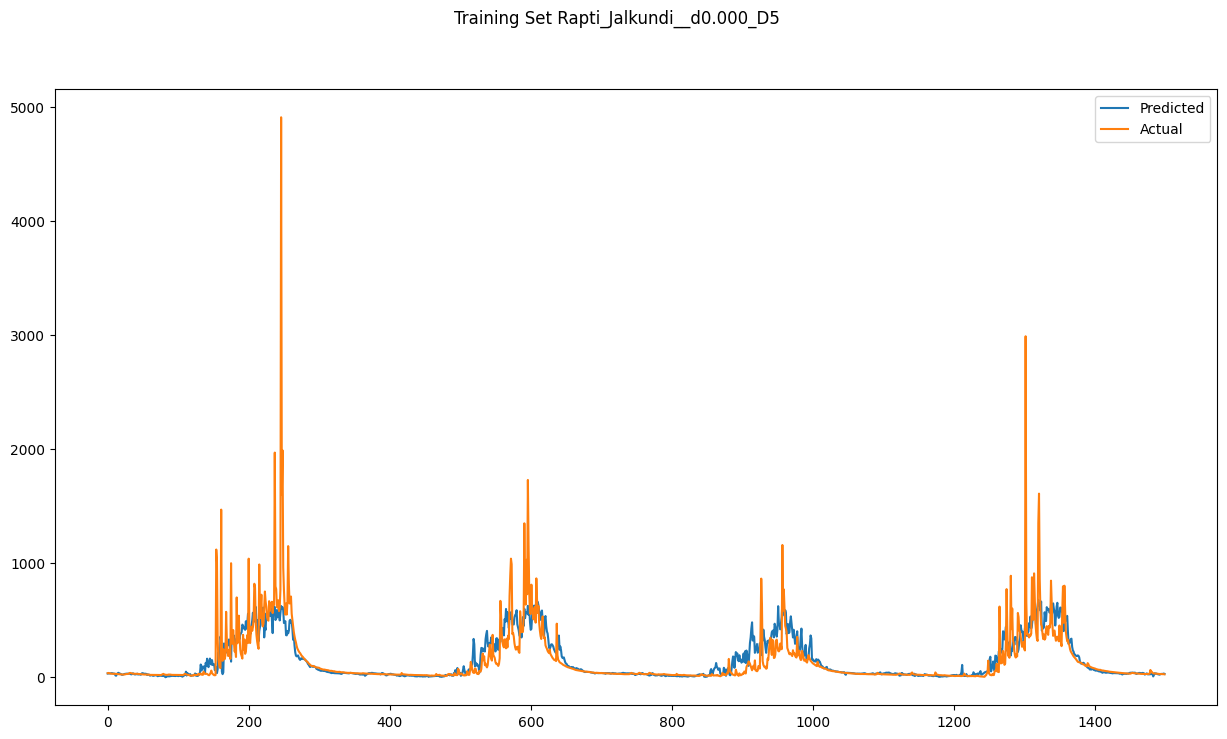

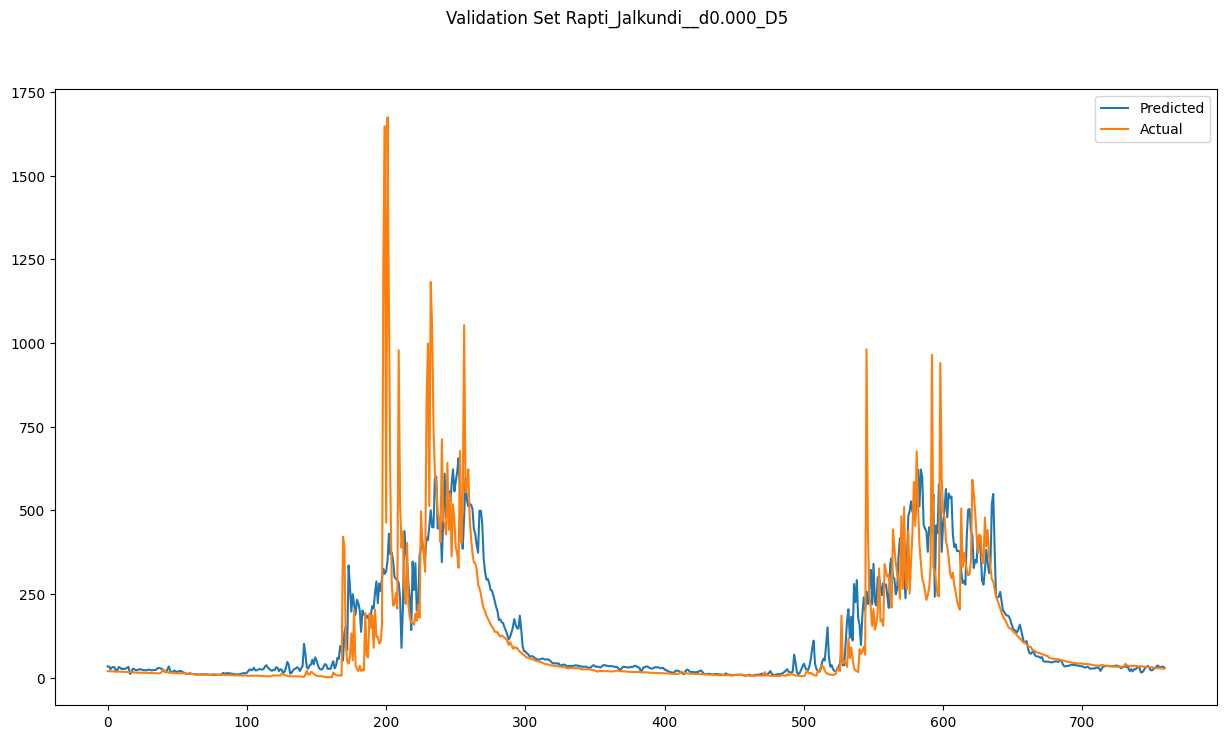

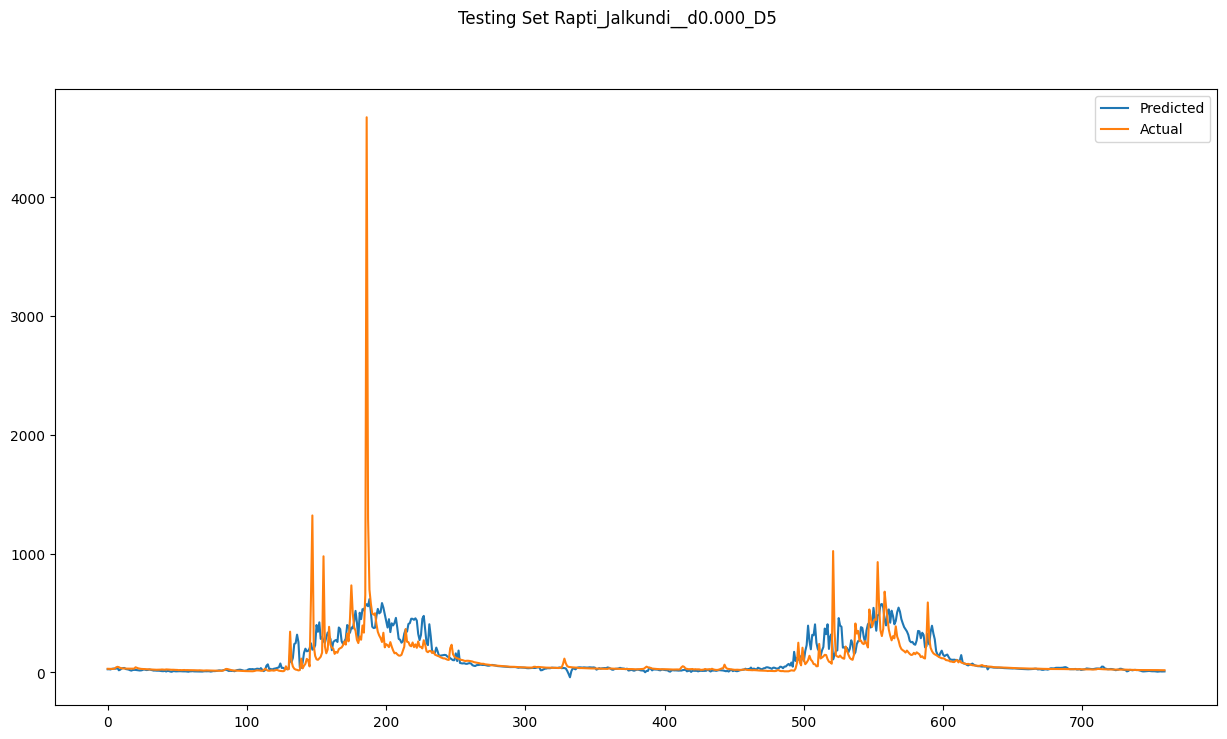

<ipython-input-11-31608e01f2a4>:225: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


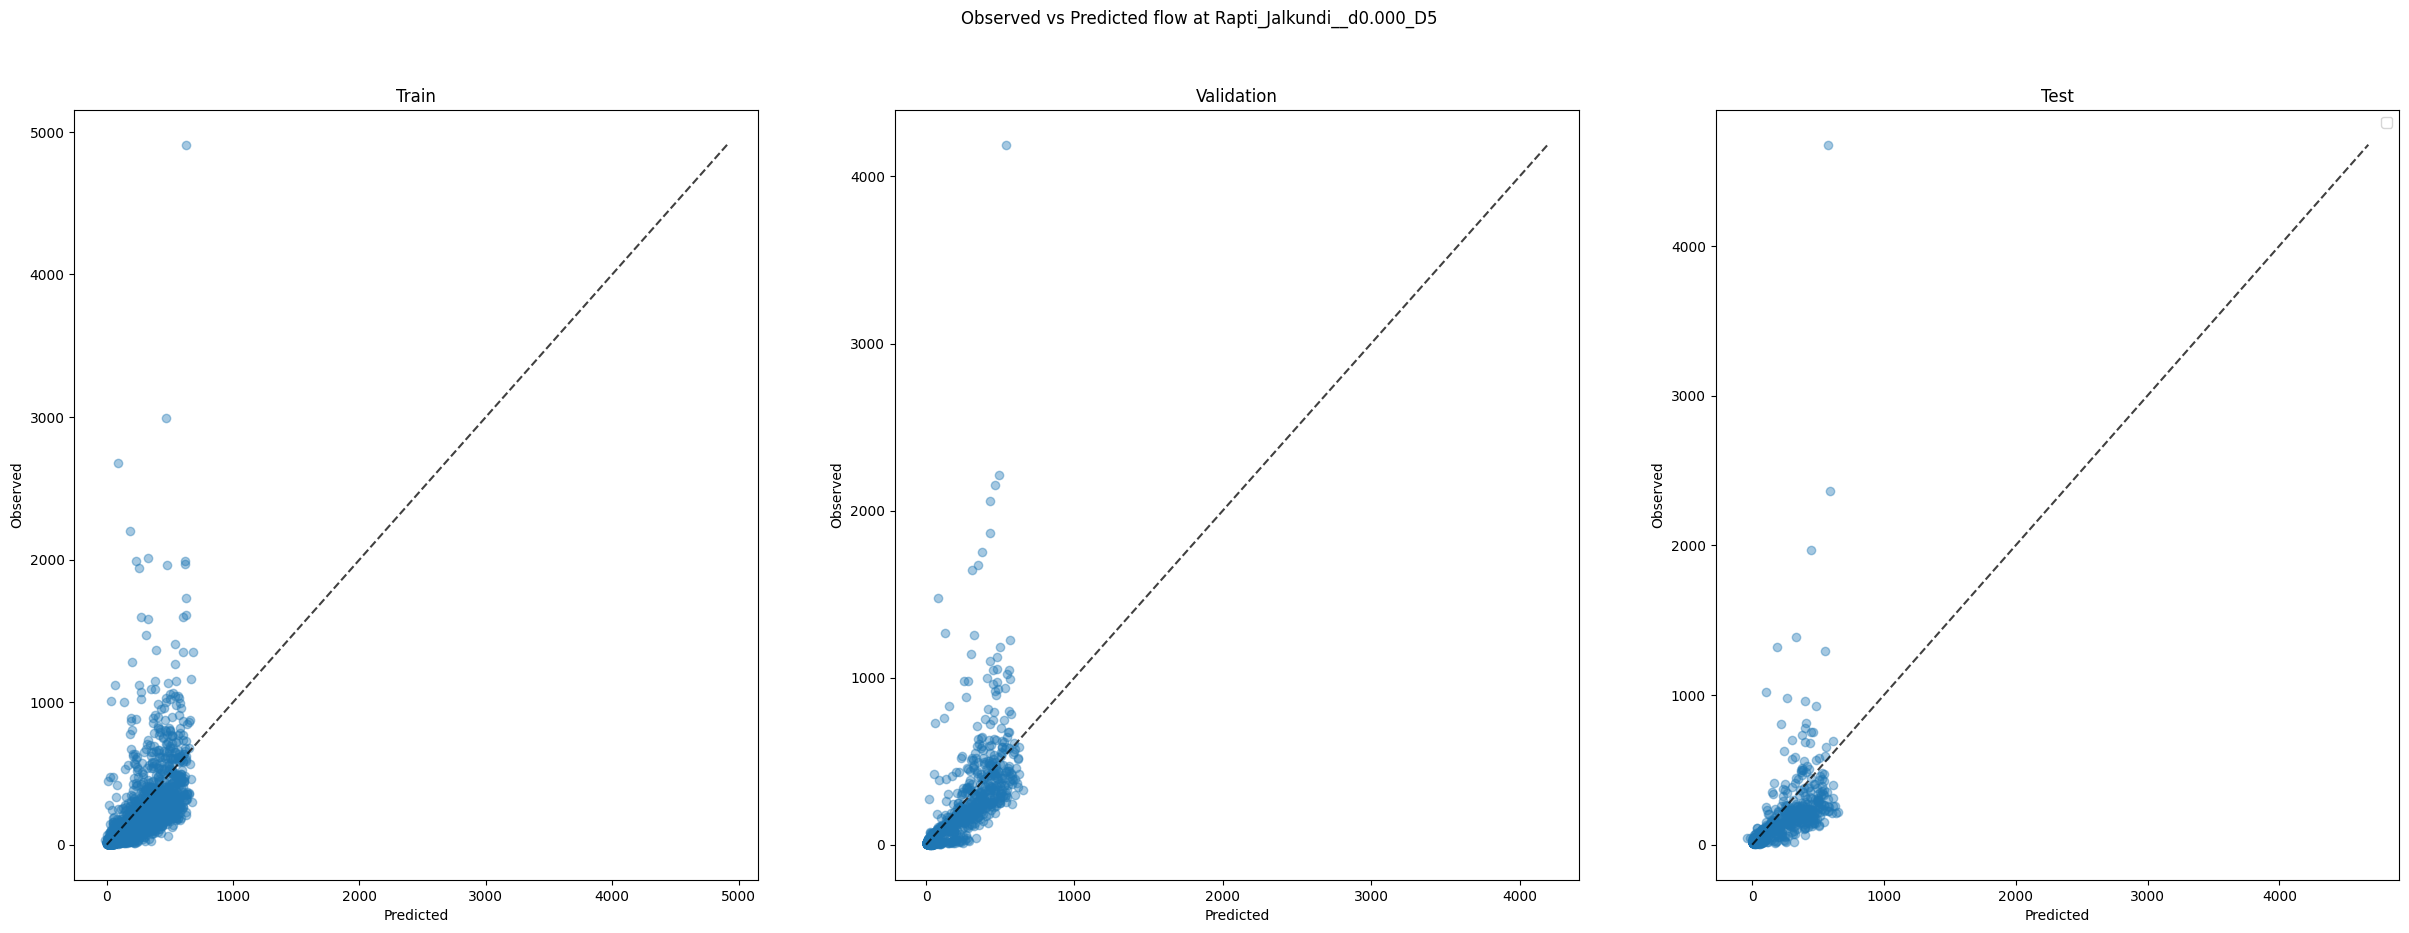

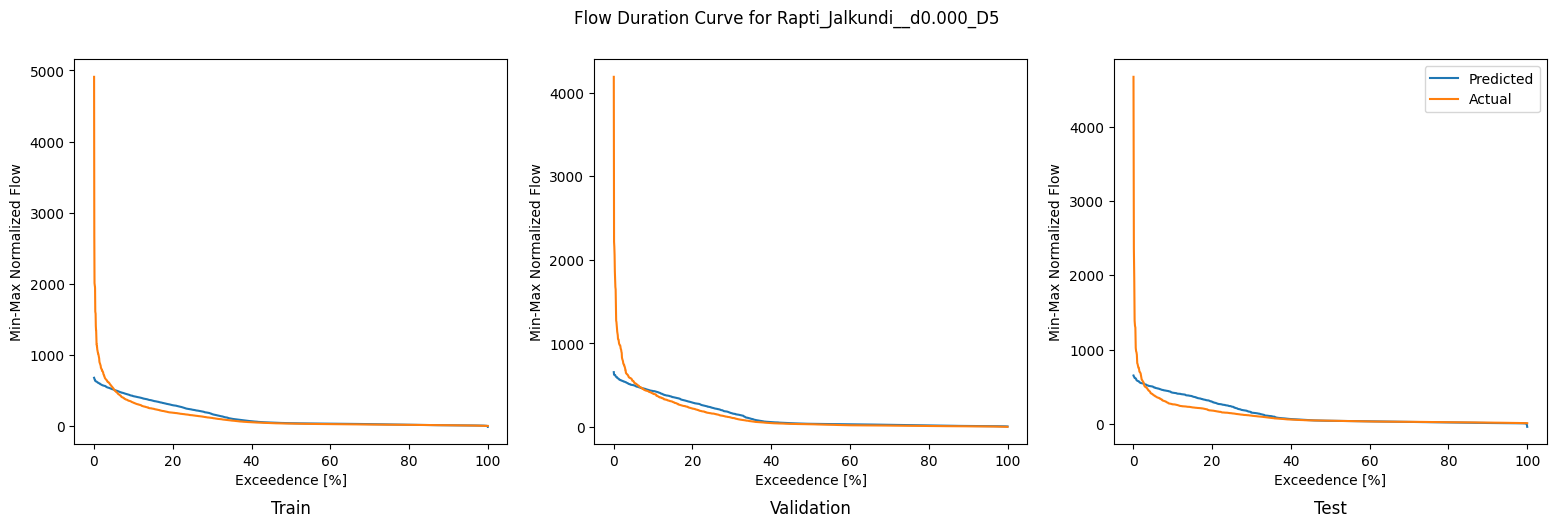

In [ ]:
for i in range(8,9): #len(all_files)
    basin_name = all_files[i][:-14]                                   # Select one basin as test
    raw_df = pd.read_csv(os.path.join(in_path,all_files[i]))
    #print(un_df)
    df_train, df_val, df_test = get_data(all_files[i],raw_df)
    train_start, train_end, val_start, val_end, test_start, test_end = get_train_val_test2(all_files[i])
    #print(df)

    out_path = '/content/drive/MyDrive/2_2/04_LSTM_midT/' + basin_name
    if not os.path.exists(out_path):
      os.makedirs(out_path)

    #a = int(input('Check:'))

    out_model_path = os.path.join(out_path, 'Model')
    out_plot_path = os.path.join(out_path, 'Plot')
    out_Q_path = os.path.join(out_path, 'Predicted')
    if not os.path.exists(out_model_path):
      os.makedirs(out_model_path)
    if not os.path.exists(out_plot_path):
      os.makedirs(out_plot_path)
    if not os.path.exists(out_Q_path):
      os.makedirs(out_Q_path)

    df_summary = pd.DataFrame(columns=['Basin','Days','Dropout','Cells','NSE_tr','NSE_vl','NSE_ts','KGE_tr','KGE_vl','KGE_ts','r_tr','r_vl','r_ts','alpha_tr','alpha_vl','alpha_ts','beta_tr','beta_vl','beta_ts' ])
    loc = 0
    for n in n_days:
        for dropout in drop_rate:
            for cell in cells:
                output.clear()
                suffix =  '_d' + str(f'{dropout:.3f}') + '_D' + str(f'{n:01d}') #+ '_c' + str(f'{cell:2d}')
                out_model = os.path.join(out_model_path, basin_name + suffix + '.keras')
                print(out_model)
                ###############
                x1,y1 = npfy(df_train,n)
                x2,y2 = npfy(df_val,n)
                x3,y3 = npfy(df_test,n)
                #print(x1.shape, y1.shape, x2.shape, y2.shape, x3.shape, y3.shape)

                #a = int(input('Check:'))
                ###############
                #Training, validation and testing data
                x_train, y_train = x1, y1
                x_val, y_val = x2, y2
                x_test, y_test = x3, y3
                x_train = x_train.astype('float32')
                x_val = x_val.astype('float32')
                x_test = x_test.astype('float32')
                y_train = y_train.astype('float32')
                y_val = y_val.astype('float32')
                y_test = y_test.astype('float32')
                del x1, y1, x2, y2, x3, y3
                print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)
                #a = int(input('Check:'))
                ###############
                #model setup
                model = Sequential()
                model.add(LSTM(cell, activation = None, return_sequences = True, input_shape = (1,x_train.shape[2]), dropout = dropout))
                #model.add(LSTM(cell, activation = None, return_sequences = True,))
                model.add(LSTM(cell, activation = None))
                model.add(Dense(1))
                model.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = l_rate), metrics = [RootMeanSquaredError()])
                print(model.summary())

                ###############
                #Callbacks
                earlyStop = EarlyStopping(monitor='val_loss',
                    patience = 8,
                    verbose = 1,
                    mode ='min',
                    restore_best_weights = True,
                    start_from_epoch = 5,
                )
                checkpoint = ModelCheckpoint(out_model,
                    verbose = 1,
                    monitor = 'val_loss',
                    save_best_only = True,
                    mode = 'min',
                )
                # reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                #     factor = 0.2,
                #     patience = 10,
                #     verbose = 1,
                #     mode = 'min',
                #     min_delta = 0.001,
                #     cooldown = 0,
                #     min_lr = 0.001,
                # )
                ###############
                #Train model
                training = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 50 , callbacks = [ checkpoint ,  earlyStop ])   #reduce_lr ,

                ###############
                #Load saved model
                model.load_weights(filepath = out_model)

                ###############
                #Make predictions
                train_predictions = model.predict(x_train).flatten()
                train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
                val_predictions = model.predict(x_val).flatten()
                val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
                test_predictions = model.predict(x_test).flatten()
                test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})

                ###############
                #Save Predictions
                df_out = raw_df[['time','Observed']]
                df_out['Predicted'] = 'None'
                df_out['Check'] = 'None'
                df_out['Predicted'][train_start+n:train_end],df_out['Check'][train_start+n:train_end] = train_results['Train Predictions'],train_results['Actuals']
                df_out['Predicted'][val_start+n:val_end],df_out['Check'][val_start+n:val_end] = val_results['Val Predictions'],val_results['Actuals']
                df_out['Predicted'][test_start+n:test_end],df_out['Check'][test_start+n:test_end] = test_results['Test Predictions'],test_results['Actuals']
                df_out = df_out[['Observed','Check','Predicted']]
                #print(df_out)
                out_file = os.path.join(out_Q_path, basin_name + suffix + '.csv')
                df_out.to_csv(out_file)
                del df_out

                ##################
                #Calculate and record statistical performance
                simulations_tr = train_results['Train Predictions']
                actuals_tr = train_results['Actuals']
                nse_tr = he.evaluator(he.nse, simulations_tr, actuals_tr)
                kge_tr, r_tr, alpha_tr, beta_tr = he.evaluator(he.kge, simulations_tr, actuals_tr)

                simulations_vl = val_results['Val Predictions']
                actuals_vl = val_results['Actuals']
                nse_vl = he.evaluator(he.nse, simulations_vl, actuals_vl)
                kge_vl, r_vl, alpha_vl, beta_vl = he.evaluator(he.kge, simulations_vl, actuals_vl)

                simulations_ts = test_results['Test Predictions']
                actuals_ts = test_results['Actuals']
                nse_ts = he.evaluator(he.nse, simulations_ts, actuals_ts)
                kge_ts, r_ts, alpha_ts, beta_ts = he.evaluator(he.kge, simulations_ts, actuals_ts)

                df_summary.loc[loc] = [basin_name,n, dropout, cell, nse_tr[0], nse_vl[0], nse_ts[0], kge_tr[0], kge_vl[0], kge_ts[0],
                                      r_tr[0], r_vl[0], r_ts[0], alpha_tr[0], alpha_vl[0], alpha_ts[0], beta_tr[0], beta_vl[0], beta_ts[0] ]
                loc += 1

                sim_ts = test_results.dropna()                                                                         #For FDC and required as only test data set contains missing observed values
                del train_predictions, val_predictions, test_predictions, train_results, val_results, test_results

                ###############
                #Hydrograph Plots
                fig, axes = plt.subplots(1,1, figsize=(15,8))
                fig.suptitle(f'Training Set {basin_name}_{suffix}')
                axes.plot(simulations_tr[:1500],label = 'Predicted')
                axes.plot(actuals_tr[:1500],label = 'Actual')
                plt.legend()
                plt.show()
                out_plot = os.path.join(out_plot_path, basin_name + '_Train' + suffix + '.png' )
                fig.savefig(out_plot)

                fig, axes = plt.subplots(1,1, figsize=(15,8))
                fig.suptitle(f'Validation Set {basin_name}_{suffix}')
                axes.plot(simulations_vl[:760],label = 'Predicted')
                axes.plot(actuals_vl[:760],label = 'Actual')
                plt.legend()
                plt.show()
                out_plot = os.path.join(out_plot_path, basin_name + '_Val' + suffix + '.png' )
                fig.savefig(out_plot)

                fig, axes = plt.subplots(1,1, figsize=(15,8))
                fig.suptitle(f'Testing Set {basin_name}_{suffix}')
                axes.plot(simulations_ts[:760],label = 'Predicted')
                axes.plot(actuals_ts[:760],label = 'Actual')
                plt.legend()
                plt.show()
                out_plot = os.path.join(out_plot_path, basin_name + '_Test' + suffix + '.png' )
                fig.savefig(out_plot)
                print()

                # #Training History
                # fig, axes = plt.subplots(2,1, figsize=(14, 8))
                # fig.suptitle(f'Training History {basin_name}_{suffix}')
                # axes[0].plot(training.history["loss"], color="#1f77b4", label="Training Loss")
                # axes[0].plot(training.history["val_loss"], linestyle=":", marker="o", markersize=3, color="#1f77b4", label="Validation Loss")
                # axes[0].set_ylabel("Loss")
                # axes[0].legend()
                # axes[1].plot(training.history["root_mean_squared_error"], color="#ff7f0e", label="MAE")
                # axes[1].plot(training.history["val_root_mean_squared_error"], linestyle=":", marker="o", markersize=3, color="#ff7f0e", label="Validation MAE")
                # axes[1].legend()
                # axes[1].set_ylabel("Mean Absolute Error")
                # axes[1].set_xticks(range(1, len(training.epoch)+1, 4))
                # axes[1].set_xticklabels(range(1, len(training.epoch)+1, 4))
                # plt.legend()
                # plt.show()
                # out_plot = os.path.join(out_plot_path, basin_name + '_History' + suffix + '.png' )
                # fig.savefig(out_plot)
                # print()

                #Observed vs Predicted
                fig, axes = plt.subplots(1,3, figsize=(30, 10))
                fig.suptitle(f'Observed vs Predicted flow at {basin_name}_{suffix}')
                axes[0].plot(simulations_tr, actuals_tr, "o", alpha=0.4)
                if simulations_tr.max() > actuals_tr.max():
                  max = simulations_tr.max()
                else:
                  max = actuals_tr.max()
                axes[0].plot([0,max], [0,max], "k--", alpha=0.75)
                axes[0].set_xlabel("Predicted")
                axes[0].set_ylabel("Observed")
                axes[0].set_title('Train')

                axes[1].plot(simulations_vl, actuals_vl, "o", alpha=0.4)
                if simulations_vl.max() > actuals_vl.max():
                  max = simulations_vl.max()
                else:
                  max = actuals_vl.max()
                axes[1].plot([0,max], [0,max], "k--", alpha=0.75)
                axes[1].set_xlabel("Predicted")
                axes[1].set_ylabel("Observed")
                axes[1].set_title('Validation')

                axes[2].plot(simulations_ts, actuals_ts, "o", alpha=0.4)
                if simulations_ts.max() > actuals_ts.max():
                  max = simulations_ts.max()
                else:
                  max = actuals_ts.max()
                axes[2].plot([0,max], [0,max], "k--", alpha=0.75)
                axes[2].set_xlabel("Predicted")
                axes[2].set_ylabel("Observed")
                axes[2].set_title('Test')
                plt.legend()
                plt.show()
                out_plot = os.path.join(out_plot_path, basin_name + '_OvP' + suffix + '.png' )
                fig.savefig(out_plot)

                ###############
                #FDC
                sort_sim_tr = np.sort(simulations_tr)[::-1]
                sort_act_tr = np.sort(actuals_tr)[::-1]
                sort_sim_vl = np.sort(simulations_vl)[::-1]
                sort_act_vl = np.sort(actuals_vl)[::-1]
                sort_sim_ts = np.sort(sim_ts['Test Predictions'])[::-1]
                sort_act_ts = np.sort(sim_ts['Actuals'])[::-1]
                exceedence_tr = np.arange(1.,len(sort_sim_tr)+1) / len(sort_sim_tr)
                exceedence_vl = np.arange(1.,len(sort_sim_vl)+1) / len(sort_sim_vl)
                exceedence_ts = np.arange(1.,len(sort_sim_ts)+1) / len(sort_sim_ts)

                fig, axes = plt.subplots(1,3, figsize=(19,5))
                fig.suptitle(f'Flow Duration Curve for {basin_name}_{suffix}')
                axes[0].plot(100*exceedence_tr,sort_sim_tr,label = 'Predicted')
                axes[0].plot(100*exceedence_tr,sort_act_tr,label = 'Actual')
                axes[0].set_xlabel("Exceedence [%]")
                axes[0].set_ylabel("Min-Max Normalized Flow")
                axes[0].set_title('Train',y = -.20)
                axes[1].plot(100*exceedence_vl,sort_sim_vl,label = 'Predicted')
                axes[1].plot(100*exceedence_vl,sort_act_vl,label = 'Actual')
                axes[1].set_xlabel("Exceedence [%]")
                axes[1].set_ylabel("Min-Max Normalized Flow")
                axes[1].set_title('Validation',y = -.20)
                axes[2].plot(100*exceedence_ts,sort_sim_ts,label = 'Predicted')
                axes[2].plot(100*exceedence_ts,sort_act_ts,label = 'Actual')
                axes[2].set_xlabel("Exceedence [%]")
                axes[2].set_ylabel("Min-Max Normalized Flow")
                axes[2].set_title('Test',y = -.20)
                plt.legend()
                plt.show()
                out_plot = os.path.join(out_plot_path, basin_name + '_FDC' + suffix + '.png' )
                fig.savefig(out_plot)

                del fig, axes, sort_sim_tr, sort_act_tr, sort_sim_vl, sort_act_vl, sort_sim_ts, sort_act_ts, exceedence_tr, exceedence_vl, exceedence_ts

                #####################
                keras.backend.clear_session()
                #####################

    df_summary.to_csv(os.path.join(out_path, basin_name  + '_Summary.csv'), index = False)
    gc.collect()